# Understanding transformations in the latent space

This notebook explores how is the data transformed within the different latent spaces using vector fields. 

<div style="text-align: center;">
    <img src="../figures/model_transformation_focus.png" alt="Figure: Focus on Transformations" width="800" height="400"/>
</div>

1. It begins by introducing the pre-defined vector fields available, providing an intuition for the parameters that define them. 
2. Next, these concepts are applied to a toy dataset to demonstrate their practical use.

# 

In [1]:
using Pkg
Pkg.activate("../")

using Distributions, Random, VegaLite, DataFrames
using CairoMakie

include("../src/scManifoldDynamics.jl") # All the functions from the project are contained in a module called "scManifoldDynamics". 
using .scManifoldDynamics  # Import the module to access its functions.


  Activating environment at `c:\Users\canall\More-than-meets-the-eye\Project.toml`


### *Introduction*: Using vector fields to simulate movement

We use vector fields to represent the directions in which points move at every location in $\mathbb{R}^2$. Given a vector field $F(x,y)$, the trajectory of a point starting at $(x_0,y_0)$ is obtained by integrating the system:

$$
\frac{d\mathbf{x}}{dt} = F(\mathbf{x}).
$$

While explicitly solving these differential equations can be complex, simply plotting the vector field $F(x,y)$ provides immediate visual insight into how points tend to move. 

To approximate the movement of points without performing the full integration, we consider the following two components:

$$
P(x,y) = x + F_1(x,y), \quad Q(x,y) = y + F_2(x,y).
$$

Here, $(P(x,y), Q(x,y))$ represents the coordinates of a point $(x,y)$ after taking a small, unit step along the direction given by $F(x,y)$. By examining these transformations for all points, we get an intuitive geometric approximation of the motion induced by the vector field.

We can create more complex vector fields by adding together simpler ones. Suppose we have several vector fields $(F^{(1)}, F^{(2)}, \dots, F^{(f)})$, where each $F^{(i)}(x,y) = (F^{(i)}_1(x,y), F^{(i)}_2(x,y))$. Defining:

$$
P(x,y) = \sum_{i=1}^f P_i(x,y) \quad \text{and} \quad Q(x,y) = \sum_{i=1}^f Q_i(x,y),
$$

where each $P_i(x,y) = x + F^{(i)}_1(x,y)$ and $Q_i(x,y) = y + F^{(i)}_2(x,y)$, allows us to combine multiple transformations—such as rotation, translation, deformation, or division—into a single vector field. If no transformations are applied (i.e., all $F^{(i)}$ are zero), the vector field reduces to the identity transformation.

### 1. Our predefined vector fields
#### The State Transition (ST) Vector Field

The **State Transition (ST)** vector field is a predefined function that combines several types of transformations into one unified framework. It can rotate clusters of points, translate them, deform their shape, or guide them toward a target location.

Formally, the ST vector field is given by:

<!-- $$
\begin{aligned}
P_{ST}(x,y) &= \cos(\alpha)(x - c_x) - \sin(\alpha)(y - c_y) + c_x + \delta_x + \frac{a_x}{x+b_x} + \frac{t_x - x}{n_x}, \\
Q_{ST}(x,y) &= \sin(\alpha)(x - c_x) + \cos(\alpha)(y - c_y) + c_y + \delta_y + \frac{a_y}{y+b_y} + \frac{t_y - y}{n_y}.
\end{aligned}
$$ -->

$$
\begin{aligned}
x' &= \cos(\alpha)(x - c_x) \;-\; \sin(\alpha)(y - c_y) \;+\; c_x \;+\; x_{linshift} \;+\; \frac{x_{push\_a}}{x + x_{push\_b}} \;+\; \frac{x_{moveto}-x}{x_{moveto\_steps}}, \\
y' &= \sin(\alpha)(x - c_x) \;+\; \cos(\alpha)(y - c_y) \;+\; c_y \;+\; y_{linshift} \;+\; \frac{y_{push\_a}}{y + y_{push\_b}} \;+\; \frac{y_{moveto}-y}{y_{moveto\_steps}}.
\end{aligned}
$$


<!-- **Parameters:**
- $\alpha$: Rotation angle around center $(c_x, c_y)$.
- $(\delta_x,\delta_y)$: Linear shifts in the $x$ and $y$ directions.
- $(a_x,b_x,a_y,b_y)$: Parameters for a nonlinear "push" effect to deform the cluster.
- $(t_x,t_y,n_x,n_y)$: Parameters guiding points toward a target location over a number of steps. -->

**Parameters:**
- $\alpha, c_x, c_y$: Determine the rotation around the point $(c_x,c_y)$.
- $x_{linshift}, y_{linshift}$: Linear shifts in the $x$ and $y$ directions.
- $x_{push\_a}, x_{push\_b}, y_{push\_a}, y_{push\_b}$: Parameters controlling a nonlinear "push" effect to deform the cluster.
- $x_{moveto}, x_{moveto\_steps}, y_{moveto}, y_{moveto\_steps}$: Parameters for guiding points toward a target location $(x_{moveto},y_{moveto})$ over a number of steps. 


By default, these parameters are set so that the ST vector field acts as the identity (with additional constrains that prevent us from dividing from 0).


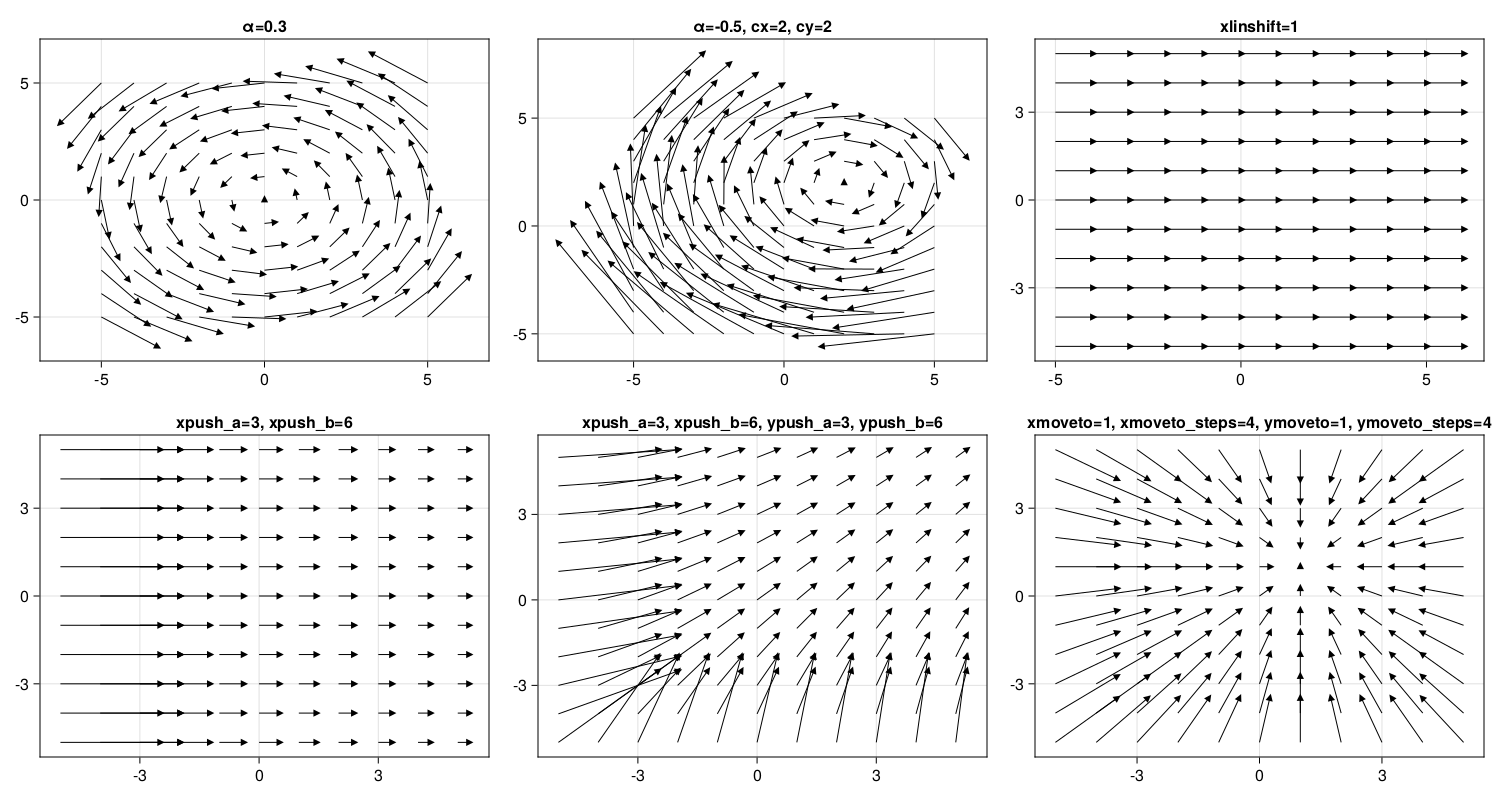

In [3]:
params_list = [
    (α=0.3,),
    (α=-0.5, cx = 2, cy = 2,),
    (xlinshift=1,),
    # (ylinshift=-1,),
    (xpush_a = 3, xpush_b = 6,),
    (xpush_a = 3, xpush_b = 6, ypush_a = 3, ypush_b = 6,),
    (xmoveto = 1, xmoveto_steps = 4, ymoveto = 1, ymoveto_steps = 4),
]
fig = Figure(resolution = (1500, 800))

g = Vector{FunctionParams}(undef, length(params_list))

for (i, params) in enumerate(params_list)
    row = (i - 1) ÷ 3 + 1
    col = (i - 1) % 3 + 1

    ax = Axis(fig[row, col])  
    g[i] = FunctionParams(fgeneral_transformation, params)
    plot_vector_field!(ax; f=g[i])  # plot_vector_field! is a function that plots in a position (ax) the vector field given by f. 
 end

fig

#### The Continuous Division (CD) Vector Field

Another predefined vector field is the **Continuous Division (CD)** field. It simulates a scenario where a cluster of points smoothly divides into different subpopulations without a harsh division line.

The CD vector field is defined as:

$$
\begin{aligned}
P_{CD}(x,y) &= x + \frac{a}{x + b}, \\
Q_{CD}(x,y) &= y + \left ( \frac{A}{1 + e^{-k(y - y_0)}} - B \right ) /C.
\end{aligned}
$$

**Parameters:**
- $(a,b)$: Control the nonlinear shift in $x$.
- $(A,k,y_0,B,C)$: Define a logistic (sigmoid) function in $y$, controlling the smoothness and symmetry of the division.

With all parameters at their defaults (all set to zero except $A=1$ and $C=1$), the transformation is, as for the ST vector field, the identity. 


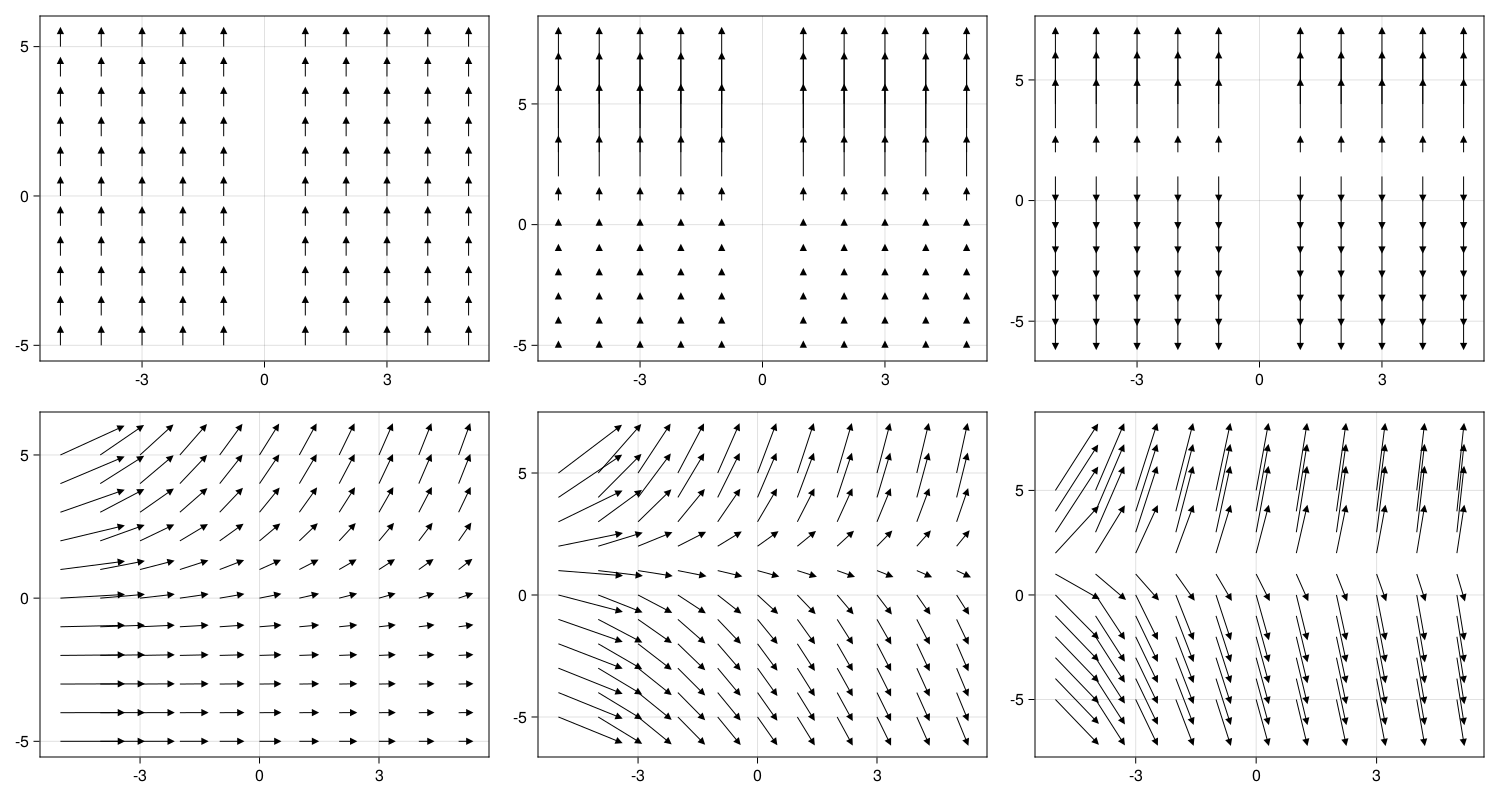

In [2]:
params_list = [
    (a = 0, b=0, A=1.0, k=0.0, y0=0.0, B=0.0, C=1.0,),
    (a = 0, b=0, A=3.0, k=2.0, y0=-2.0, B=0.0, C=1.0,),
    (a = 0, b=0, A=3.0, k=3.0, y0=-2.0, B=1.0, C=1.0,),
    (a = 3, b=7, A=1.0, k=1.0, y0=-2.0, B=0.0, C=1.0,),
    (a = 3, b=7, A=3.0, k=1.0, y0=-2.0, B=1.0, C=1.0,),
    (a = 2, b=7, A=5.0, k=3.0, y0=-1.5, B=2.0, C=1.0,),
]
fig = Figure(resolution = (1500, 800))

h = Vector{FunctionParams}(undef, length(params_list))

for (i, params) in enumerate(params_list)
    row = (i - 1) ÷ 3 + 1
    col = (i - 1) % 3 + 1

    ax = Axis(fig[row, col])
    h[i] = FunctionParams(fdivide_countinuous, params)
    plot_vector_field!(ax; f=h[i], show_title=false)  
end

fig 

It is worth mentioning that while there apart from the Continuous Division vector field, one can also divide a cluster using a simple linear boundary. This approach can emulate a scenario where a biological condition creates a partition of the cell population, as we see in the following cell.

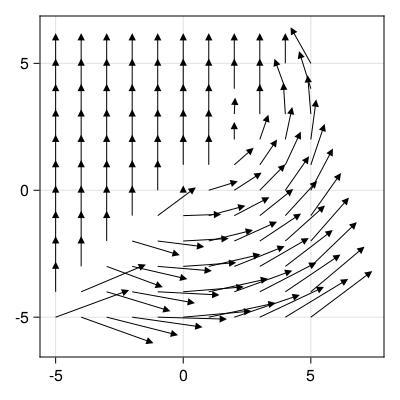

In [3]:
fa = FunctionParams(fgeneral_transformation, (ylinshift=1,)) # fa denotes the transformation that will be applied above the separation line
fb = FunctionParams(fgeneral_transformation, (α=0.3, xlinshift=1))  # fb denotes the transformation that will be applied below the separation line

fd = FunctionParams(divide_cluster, (m=1, n=0, fa=fa, fb=fb, sigma=0.7,)) # Combines the transformations above (fa) and below (fb) the separation line 
# given by y=mx+n into a unified function for cluster division.

plot_vf = plot_vector_field(fd; show_title=false)
plot_vf

### 2. Applying Vector Fields to Toy Data

To illustrate how these transformations work in practice, let's consider some toy data composed of two simple clouds of points in $ \mathbb{R}^2 $. 

In [4]:
# Util function to create two simulated cloud points:
function generate_clouds(; 
    means::AbstractVector{<:AbstractVector{<:Number}}, 
    stds::AbstractVector{<:AbstractVector{<:Number}}, 
    counts::AbstractVector{<:Integer}
)
    df_cloud = DataFrame(x = Float64[], y = Float64[], label = String[], cloud_number = Int[])

    for (i, (mean, std, n)) in enumerate(zip(means, stds, counts))
        x_coords = mean[1] .+ std[1] * randn(n)
        y_coords = mean[2] .+ std[2] * randn(n)
        new_data = DataFrame(x = x_coords, y = y_coords, label = "Cloud $i", cloud_number = i)
        append!(df_cloud, new_data)
    end

    unique_clouds = unique(df_cloud.label)
    c = [findall(x -> x == cloud, df_cloud.label) for cloud in unique_clouds]

    return df_cloud, c
end


generate_clouds (generic function with 1 method)

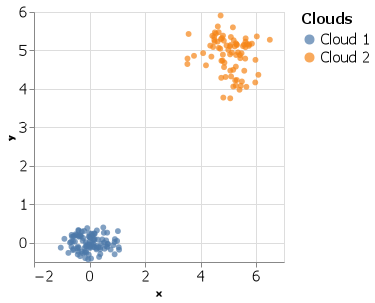

In [5]:
cloud_params = (
    means = [[0.0, 0.0], [5.0, 5.0]],  
    stds = [[0.5, 0.2], [0.5, 0.5]],  
    counts = [100, 80]          
)     

Random.seed!(1013)
df_toy_data, c = generate_clouds(; cloud_params...)
toy_data = [df_toy_data.x df_toy_data.y]

# We can visualise the generated toy data
df_toy_data |> @vlplot(
    width=250,
    height=250,
    :circle, 
    x={:x, title="x", axis={titleFontSize=10, labelFontSize=15, tickCount=5}},
    y={:y, title="y", axis={titleFontSize=10, labelFontSize=15, tickCount=5}},
    color={"label:n", scale={scheme="tableau10"}, legend={title="Clouds", orient="right", titleFontSize=15, labelFontSize=15}},
    size={value=35}
)

1. Define the list of parameters that we want to explore for the ST vector field. As these are illustrative examples, we will apply them to one of the two clouds of toy data. 


In [7]:
params_list = [
    (α=0.3,),
    (α=-0.5, cx = 2, cy = 2,),
    (ypush_a = 2, ypush_b = -8,),
    (xmoveto = 1, xmoveto_steps = 4, ymoveto = 1, ymoveto_steps = 4,),
    (xmoveto = 2, xmoveto_steps = 4, ymoveto = 3, ymoveto_steps = -4,)
]

5-element Vector{NamedTuple}:
 (α = 0.3,)
 (α = -0.5, cx = 2, cy = 2)
 (ypush_a = 2, ypush_b = -8)
 (xmoveto = 1, xmoveto_steps = 4, ymoveto = 1, ymoveto_steps = 4)
 (xmoveto = 2, xmoveto_steps = 4, ymoveto = 3, ymoveto_steps = -4)

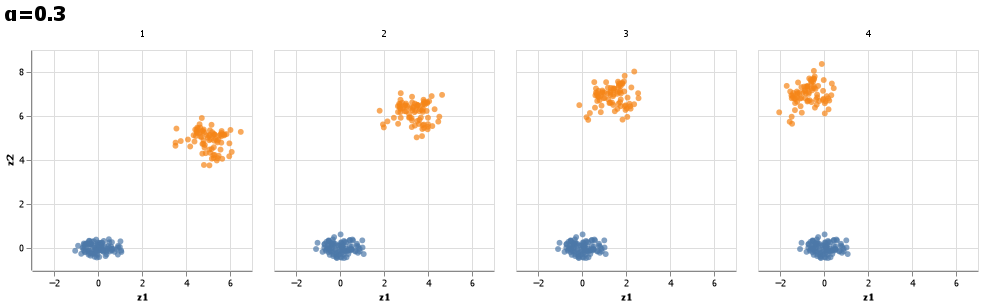

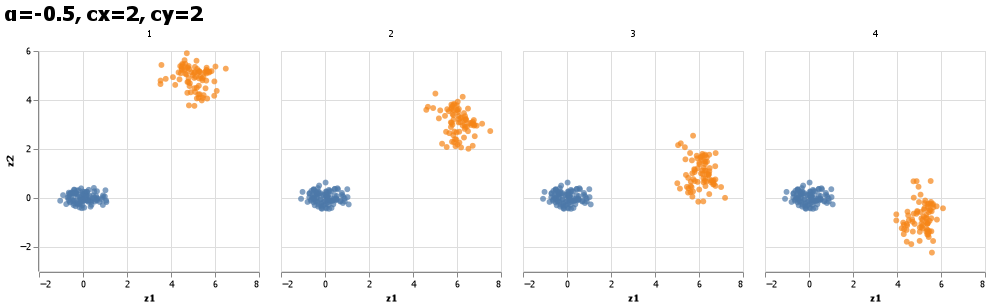

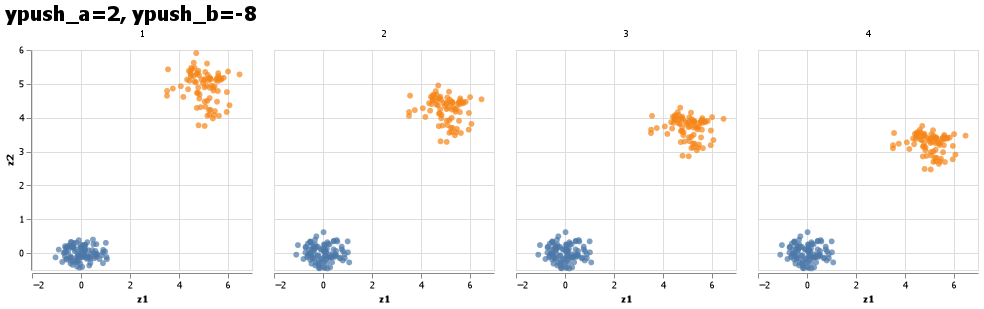

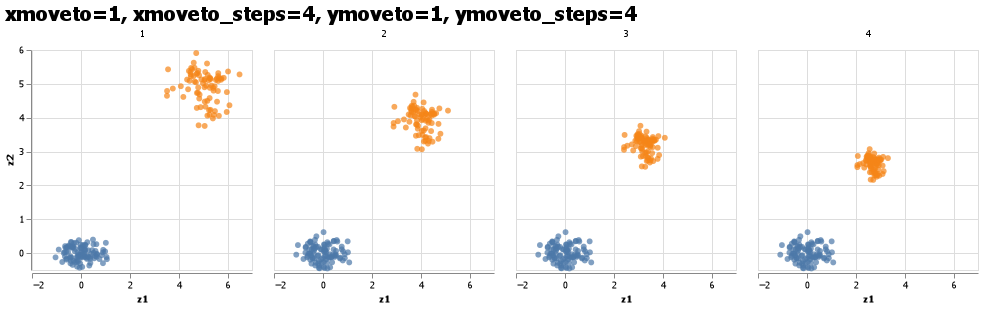

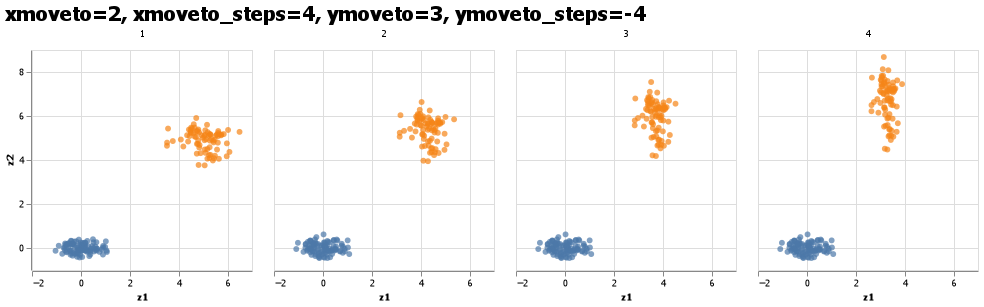

In [9]:
n_examples = length(params_list)
ind_clusterchange = [2] # Change to 1 to apply it to cloud 1 (or [1,2] in case you want to apply it to both and compare)
ntimepoints = 4
ncelltypes = length(c)

latent_examples = Vector{Array{Float32, 3}}(undef, n_examples)
example_transformations = Vector{FunctionParams}(undef, n_examples)
h = Vector{FunctionParams}(undef, ncelltypes) # h stores the function that will be applied to each cluster (i.e h[1] the transformation that is to be 
# applied to cluster 1 and so on. The number of the cluster is given by the vector c.)

# Create transformation functions for each example from the params_list
for (i, params) in enumerate(params_list) 
    example_transformations[i] = FunctionParams(fgeneral_transformation, params)
end

# Assign transformations to the designated cell clouds (information given by ind_clusterchange)
for (i, transformation) in enumerate(example_transformations)
    for idx in ind_clusterchange
        h[idx] = transformation
    end
    latent_examples[i] = transform_data(ntimepoints, ind_clusterchange, toy_data, c, h)
end

plots_examples = [plot_tf_data_t(latent_examples[i]; transformation_function = example_transformations[i], ntimepoints=ntimepoints, cell_annotation = df_toy_data.label) for i in 1:n_examples]

for plot in plots_examples
    display(plot)
end


2. We can also test the two different division cluster functions.

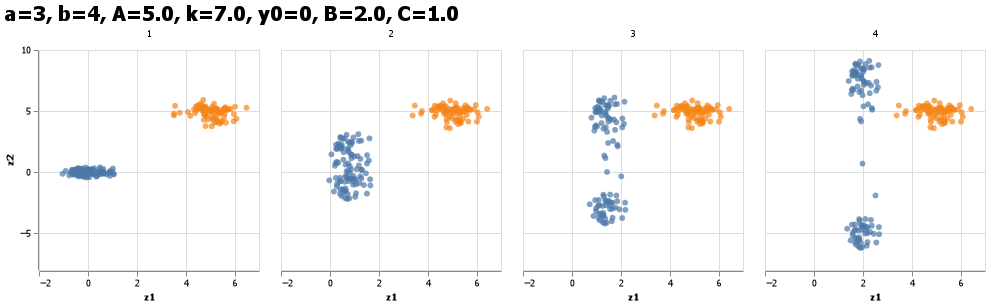

In [12]:
ind_clusterchange = [1]
h[1] = FunctionParams(fdivide_countinuous, (a = 3, b=4, A=5.0, k=7.0, y0=0, B=2.0, C=1.0,)) 

latent_example_clusterdivision = transform_data(ntimepoints, ind_clusterchange, toy_data, c, h)

plots_example_clusterdivision = plot_tf_data_t(latent_example_clusterdivision; transformation_function = h[1], ntimepoints=ntimepoints, cell_annotation = df_toy_data.label)

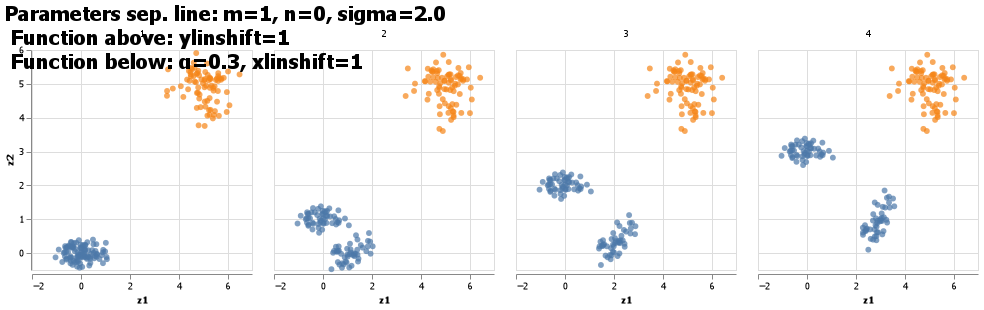

In [14]:
ind_clusterchange = [1]

fa = FunctionParams(fgeneral_transformation, (ylinshift=1,))
fb = FunctionParams(fgeneral_transformation, (α=0.3, xlinshift=1))

fd = FunctionParams(divide_cluster, (m=1, n=0, fa=fa, fb=fb, sigma=2.0,))
h[1] = fd

latent_example_clusterdivision = transform_data(ntimepoints, ind_clusterchange, toy_data, c, h)

plots_example_clusterdivision = plot_tf_data_t(latent_example_clusterdivision; transformation_function=fd, cell_annotation=df_toy_data.label)